## Systematic Testing of Compass Codes Under Code-Capacity Model
### Helper Functions
* Approximately Uniform Gauge Fixings of Lattice
    * Way to define "approximately uniform" rigorously?
* Surface-density of particular coloring of lattice
### Parameters
* Lattice Size:
    * Fix noise model and decoding algorithm, measure how logical error rate scales with lattice size for randomly chosen gauge fixings
* Gauge Fixings:
    * Higher Concentration in one region (E, W, N S, NW, NE, SW, SE **OR** U, D, L, R, UR, UL, DR, DL)
    * Higher concentration of one type (More X -> More +1; More Z -> More -1; Less of Both -> More 0)

* Noise Model:
    * Type:
        * Code-Capacity
    * Strength:
        * Vary strength of Pauli noise
    * Bias:
        * Bias more towards bit-flips or vice versa
    * Spatial:
        * Spatially bias noise more in one region than another
* Surface Density:
    * See how logical error rate scales with different densities of gauge fixings for a fixed noise model and decoding algorithm
* Decoding Algorithms:
    * Minimum-Weight Perfect Matching (MWPM)
    * Union-Find (UF)
    * Belief Propagation + Ordered Statistics Decoding (BP+OSD)
    * BP-Matching 
    * BP-Find 
    * Others?


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from lib.stabilizer import measurement_gadgets, StabilizerCode, stabilizer_circuits
from lib.color_compass import *
from lib.decoder import checkmatrix,pL_from_checkmatrix
from lib.stim2pymatching import estimate_pL_noisy_graph
import stimcirq
from typing import *
from cirq.contrib.svg import SVGCircuit
import networkx as nx
import time
from tqdm import tqdm
import scipy.stats as ss
import pickle
from pymatching import Matching
from ldpc import bposd_decoder

%load_ext autoreload
%autoreload 2

## Helper Functions + Classes

In [2]:
class Lattice2D():
    """
    convention: 
    X coords extend vertically |
    Z coords extend horizontally --
    store the coloring as a list with values in {-1, 0, 1}
    
    Red  ~ -1 ~ Z-type cuts
    Blue ~ +1 ~ X-type cuts
    White ~ 0
    
    preallocate logical X and L as cuts accross the lattice
    """
    def __init__(self, dimX, dimZ):
        self.dimX = dimX
        self.dimZ = dimZ
        self.colors = [0] * (dimX-1)*(dimZ-1)
        self.stabs = bacon_shor_group(dimX, dimZ)
        self.gauge = bsgauge_group(dimX, dimZ)
        self.Lx = ''.join(['X']*dimX+['_']*dimX*(dimZ-1))
        self.Lz = ''.join((['Z']+['_']*(dimX-1))*dimZ)
        self.logicals = [self.Lx,self.Lz]
        
    def size(self):
        return self.dimX*self.dimZ
        
    def __str__(self):
        vertex_rows = []
        face_rows = []
        dimX = self.dimX
        dimZ = self.dimZ
        for i in range(dimX):
            vertex_string = ''
            for j in range(dimZ):
                vertex_string += str(i*dimZ + j).zfill(3)
                if (j != dimZ-1):
                    vertex_string += '---'
            vertex_rows.append(vertex_string)
                
        for i in range(dimX-1):
            face_string = ''
            for j in range(dimZ-1):
                if(self.colors[i*(dimZ-1) + j] == -1):
                    # face_string += ' | '+colored(' # ', 'red')
                    face_string += ' | ' + ' ░ '
                elif(self.colors[i*(dimZ-1) + j] == +1):
                    # face_string += ' | '+colored(' # ', 'blue')
                    face_string += ' | ' + ' ▓ '
                elif(self.colors[i*(dimZ-1) + j] == 0):
                    face_string += ' |    '
                else:
                    raise ValueError(f'Invalid color type {self.colors[i*dimZ+j]}')
                if j == dimZ-2:
                    face_string += ' |'
            face_rows.append(face_string)
        sout = ''
        for idx, row in enumerate(vertex_rows):
            sout += row +'\n'
            if idx != len(vertex_rows)-1:
                sout += face_rows[idx]+'\n'
        return sout
    
    def size(self):
        return self.dimX*self.dimZ
    
    def getG(self):
        return self.gauge[0]+self.gauge[1]
    
    def getGx(self):
        return self.gauge[0]
    
    def getGz(self):
        return self.gauge[1]
    
    def getS(self):
        return self.stabs[0]+self.stabs[1]
    
    def getSx(self):
        return self.stabs[0]
    
    def getSz(self):
        return self.stabs[1]
    
    def getDims(self):
        return (self.dimX, self.dimZ)
    
    def max_stab_number(self):
        return self.dimX*self.dimZ - 1
    
    def pcheckZ(self):
        """returns the Z parity check matrix"""
        return np.vstack([pauli2vector(s) for s in self.getSz()])
        
    def pcheckX(self):
        """returns the X parity check matrix"""
        return np.vstack([pauli2vector(s) for s in self.getSx()])
    
    def display(self, pauli):
        dimX = self.dimX
        dimZ = self.dimZ
        if (len(pauli) != dimX*dimZ):
            raise ValueError("Pauli string dimension mismatch with lattice size")
        sout = ''
        slist = list(pauli)
        for i in range(dimX):
            for j in range(dimZ):
                if slist[i*dimZ+j] == 'X':
                    sout += ' X '
                elif slist[i*dimZ+j] == 'Z':
                    sout += ' Z '
                else:
                    sout += '   '
                if (j != dimZ-1):
                    sout += '---'
            if (i != dimX -1):
                sout += '\n'
                sout += ' |    '*dimZ
            sout += '\n'
        print(sout)
        
    def color_lattice(self, colors):
        """
        replace color state with input and recalculate stab and gauge groups 
        """
        dimX = self.dimX-1
        dimZ = self.dimZ-1
        if(len(colors) != dimX*dimZ):
            raise ValueError("Color dimension mismatch with lattice size")
        
        self.stabs = bacon_shor_group(self.dimX, self.dimZ)
        self.gauge = bsgauge_group(self.dimX, self.dimZ)
        self.colors = colors
        
        
        for cidx, c in enumerate(colors):
            if c == -1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), -1)
            elif c == +1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), +1)
        
        
    def update_groups(self, coords, cut_type):
        """
        cut the stabilizer group by coloring the face with the given type
            AND
        update the gauge group 
    
        algo: 
        [0] pick the gauge operator g to cut around
        [1] find s \in S that has weight-2 overlap with g
        [2] divide that s 
        [3] update the gauge group 
        """
        (i, j) = coords
        dimX = self.dimX
        dimZ = self.dimZ
        [Sx, Sz] = self.getSx(), self.getSz()
        [Gx, Gz] = self.getGx(), self.getGz()
        
        if cut_type == -1:
            # -1 = red which is a Z-cut
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'Z'
            g[i*dimZ + j + 1] = 'Z'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sz):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two vertical parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, i+1):
                        s1[k*dimZ + j] = s[k*dimZ + j]
                        s1[k*dimZ + j+1] = s[k*dimZ + j+1]
                    for k in range(i+1, dimX):
                        s2[k*dimZ + j] = s[k*dimZ + j]
                        s2[k*dimZ + j+1] = s[k*dimZ + j+1]
                    del Sz[idx]
                    Sz.append(''.join(s1))
                    Sz.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[k + i*dimZ] = 'Z'
                gauge[k + i*dimZ + 1] = 'Z'
            Gx_new = []
            for g in Gx:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gx_new.append(g)
            Gx = Gx_new
                
        elif cut_type == +1:
            # +1 = blue that is a X-cut:
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'X'
            g[(i+1)*dimZ + j ] = 'X'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sx):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two horizontal parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, j+1):
                        s1[i*dimZ + k] = s[i*dimZ + k]
                        s1[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    for k in range(j+1, dimZ):
                        s2[i*dimZ + k] = s[i*dimZ + k]
                        s2[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    del Sx[idx]
                    Sx.append(''.join(s1))
                    Sx.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[k + i*dimZ] = 'X'
                gauge[k + (i+1)*dimZ] = 'X'
            Gz_new = []
            for g in Gz:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gz_new.append(g)
            Gz = Gz_new

        # update the groups
        self.stabs = [Sx, Sz]
        self.gauge = [Gx, Gz]
        
    def error_is_corrected(self, syn, l_1, l_2, l_op):
        #syn is a vector of syndrome measurements, which has the Sx syndrome bits first
        #l_1, l_2 are booleans corresponding to the logical operator measurement
        #l_op is the logical operator we're measuring, written as a stim Pauli string

        #also need to know the stabilizers to feed into the decoder

        #check parity of l_1, l_2. If they are the same: no logical error
        #If they are different: logical error
        logical_error = ((l_1+l_2) % 2 == 0)

        #syndrome measurement gives a syndrome s. Feed into decoder to get a correction operator c
        #set up decoder
        Sx = lat.getSx()
        Sz = lat.getSz()
        Hx = np.array([[1 if i != '_' else 0 for i in s] for s in Sx])
        Hz = np.array([[1 if i != '_' else 0 for i in s] for s in Sz])
        Mx = Matching(Hx)
        Mz = Matching(Hz)

        #obtain correction operator
        cx = Mx.decode(syn[:len(Sx)])
        cz = Mz.decode(syn[len(Sx):])
        Rx = stim.PauliString(''.join(['X' if i == 1 else '_' for i in cx]))
        Rz = stim.PauliString(''.join(['Z' if i == 1 else '_' for i in cz]))

        correction_op = Rx*Rz



        #check [c, l]
            #If l_1 = l_2 and [c, l_op] = 0, then the error has been properly corrected
            #in that c keeps the proper eigenstate
            #If l_1 = l_2 and [c, l_op] \neq 0, then the decoder takes the state out of the correct eigenstate
            #If l_1 \neq l_2 and [c,l_op] = 0, then the decoder fails to correct the error
            #If l_1 \neq l_2 and [c, l_op] \neq 0, then the decoder properly corrects the error
        is_corrected = (correction_op.commutes(l_op) != logical_error)

        return is_corrected

In [3]:
def choose_gauge_fixing(dimX : int, dimY: int, type : List = None, region : List = None): 
    """ 
    Based on the type of gauge fixing specified, return something that reflects this

    Params:
    * dimX - Dimension of lattice in X direction
    * dimY - Dimension of lattice in Y direction
    * type - 
        ^ +1 - Z-type 
        ^ 0 - no gauge fix
        ^ -1 - X-type
        ^ Combine 
        ^ None - Uniform
    * region - 
        ^ [C, N, S, E, W, NE, NW, SE, SW]
        ^ None - Uniform
    """
    dimX -= 1 
    dimY -= 1
    coloring = np.zeros((dimX, dimY), dtype=int)
    
    

In [4]:
"""Sample a random Pauli error
    for now, I'll assume biased, symmetric, uncorrelated Pauli channel
"""
import random

def random_pauli(num_qubits : int, rates : list):
    assert rates[0] + rates[1] + rates[2] <= 1, "Error rate must not exceed 1"""
    paulis = []
    for i in range(num_qubits):
        x = random.uniform(0, 1)
        if x <= rates[0]: 
            paulis.append('X')
        elif x <= rates[0] + rates[1]:
            paulis.append('Y')
        elif x <= rates[0] + rates[1] + rates[2]:
            paulis.append('Z')
        else:
            paulis.append('_')
    return ''.join(paulis)

def pcheck_clipZ(pcheck):
    """
    clip (remove) the 1st half of the parity check matrix
    """
    L = int(pcheck.shape[1]/2)
    return pcheck[:, L:]

def pcheck_clipX(pcheck):
    """
    clip (remove) the 2nd half of the parity check matrix
    """
    L = int(pcheck.shape[1]/2)
    return pcheck[:, :L]

### Testing (uniform, random gauge fixings)
* Choose a decoding algorithm
* Test #1 Structure:
    * $n$ gauge fixings
    * $m$ different errors of fixed noise model per gauge-fixing
    * Plot histogram of logical error rate for each 
* Test #2 Structure:
    * Same as Test #1 but now vary size of lattice
* Test #3 Structure:
    * Let noise be normally distributed for each of X, Y, and Z.
    * Follow Test #1 structure


### Minimum-Weight Perfect Matching

### Test #1

In [10]:
dim = 8 

rates = [0.03, 0.03, 0.03]
num_gauge_fixings = 100
num_errors = 2000 
codespace_projection = np.zeros((num_gauge_fixings, num_errors))
logical_errors = np.zeros((num_gauge_fixings, num_errors))
uncorrected_logical_error_rate = np.zeros((num_gauge_fixings, num_errors))
for fix_num in tqdm(range(num_gauge_fixings)):
    lat = Lattice2D(dim, dim)
    coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
    lat.color_lattice(coloring)
    for num_error in range(num_errors):
        E = random_pauli(lat.size(), rates)
        while E == 'I' * lat.size():
            E = random_pauli(lat.size(), rates)
        error = pauli2vector(E)
        pcheckX = lat.pcheckX()
        pcheckZ = lat.pcheckZ() 
        pcheck = np.vstack((pcheckX, pcheckZ))
        syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
        syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
        Hx = pcheck_clipX(pcheckX)
        Hz = pcheck_clipZ(pcheckZ)
        decodingX = Matching.from_check_matrix(Hx)
        decodingZ = Matching.from_check_matrix(Hz)
        recoveryX = decodingX.decode(syndromeZ)
        recoveryZ = decodingZ.decode(syndromeX)
        recovery = np.concatenate((recoveryZ, recoveryX))
        corrected_error = pauli2vector(E) + recovery % 2 

        if sum(twisted_product(pcheck, corrected_error)) > 0:
            codespace_projection[fix_num][num_error] = 1
        if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
            logical_errors[fix_num][num_error] = 1
        if (twisted_product(pauli2vector(lat.Lx), error) == 1) or (twisted_product(pauli2vector(lat.Lz), error) == 1):
            uncorrected_logical_error_rate[fix_num][num_error] = 1

assert(np.sum(codespace_projection) == 0)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [06:15<00:00,  3.76s/it]


In [169]:
logical_error_rates = []
for row in logical_errors:
    logical_error_rates.append(sum(row)/len(row))

with open('data/logical_err_rate_MWPM_test_1.pkl', 'wb') as fp:
    pickle.dump(logical_error_rates_dict, fp)

Text(0.5, 1.0, 'Average Logical Error Rate over Uniformly-Random Gauge Fixings')

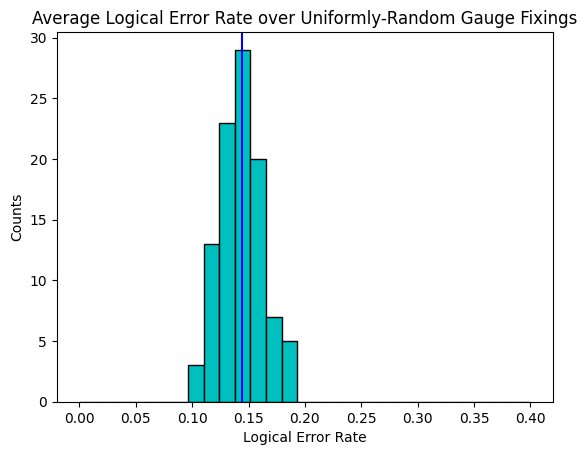

In [170]:
bins = np.linspace(0,0.4, 30)
plt.hist(logical_error_rates, bins, color='c', edgecolor='k')
plt.xlabel("Logical Error Rate")
plt.ylabel("Counts")
plt.axvline(np.mean(logical_error_rates), color='b')
plt.title("Average Logical Error Rate over Uniformly-Random Gauge Fixings")


### Test #2

In [68]:
dims = [3,4,5,6,7,8,9,10]
rates = [0.1, 0.1, 0.1]
num_gauge_fixings = 100
num_errors = 200
codespace_projection = {dim : np.zeros((num_gauge_fixings, num_errors)) for dim in dims}
logical_errors = {dim : np.zeros((num_gauge_fixings, num_errors)) for dim in dims}
uncorrected_logical_error_rate = {dim : np.zeros((num_gauge_fixings, num_errors)) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
        lat.color_lattice(coloring)
        for num_error in range(num_errors):
            E = random_pauli(lat.size(), rates)
            while E == 'I' * lat.size():
                E = random_pauli(lat.size(), rates)
            error = pauli2vector(E)
            pcheckX = lat.pcheckX()
            pcheckZ = lat.pcheckZ() 
            pcheck = np.vstack((pcheckX, pcheckZ))
            syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
            syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
            Hx = pcheck_clipX(pcheckX)
            Hz = pcheck_clipZ(pcheckZ)
            decodingX = Matching.from_check_matrix(Hx)
            decodingZ = Matching.from_check_matrix(Hz)
            recoveryX = decodingX.decode(syndromeZ)
            recoveryZ = decodingZ.decode(syndromeX)
            recovery = np.concatenate((recoveryZ, recoveryX))
            corrected_error = pauli2vector(E) + recovery % 2 

            if sum(twisted_product(pcheck, corrected_error)) > 0:
                codespace_projection[dim][fix_num][num_error] = 1
            if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                logical_errors[dim][fix_num][num_error] = 1
            if (twisted_product(pauli2vector(lat.Lx), error) == 1) or (twisted_product(pauli2vector(lat.Lz), error) == 1):
                uncorrected_logical_error_rate[dim][fix_num][num_error] = 1


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [02:41<00:00, 20.19s/it]


In [73]:
logical_error_rates_dict = {dim : [] for dim in dims}
for dim in dims:
    for row in logical_errors[dim]:
        logical_error_rates_dict[dim].append(sum(row)/len(row))

with open('data/logical_err_rate_MWPM_test_2.pkl', 'wb') as fp:
    pickle.dump(logical_error_rates_dict, fp)

KeyError: 3

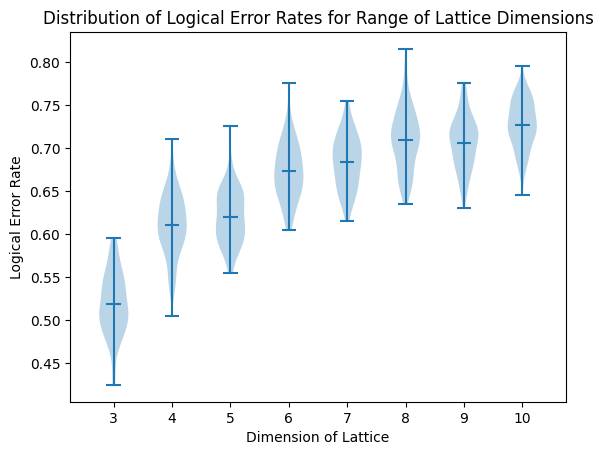

In [70]:
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Dimension of Lattice')

fig, ax = plt.subplots(1,1)
logical_error_rates_data = [logical_error_rates_dict[dim] for dim in dims]
ax.violinplot(logical_error_rates_data, showmeans=True)
ax.set_ylabel("Logical Error Rate")
ax.set_title("Distribution of Logical Error Rates for Range of Lattice Dimensions")
set_axis_style(ax, dims)
plt.show()

### Test #3

In [86]:
dims = [3,4,5,6,7,8,9,10]
num_gauge_fixings = 100
num_errors = 2000 
codespace_projection = {dim : np.zeros((num_gauge_fixings, num_errors)) for dim in dims}
logical_errors = {dim : np.zeros((num_gauge_fixings, num_errors)) for dim in dims}
uncorrected_logical_error_rate = {dim : np.zeros((num_gauge_fixings, num_errors)) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
        lat.color_lattice(coloring)
        rate = np.random.normal(0.025, 0.01)
        rates = [rate, rate, rate]
        # rates = [0.04, 0.04, 0.04]
        for num_error in range(num_errors):
            E = random_pauli(lat.size(), rates)
            while E == 'I' * lat.size():
                E = random_pauli(lat.size(), rates)
            error = pauli2vector(E)
            pcheckX = lat.pcheckX()
            pcheckZ = lat.pcheckZ() 
            pcheck = np.vstack((pcheckX, pcheckZ))
            syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
            syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
            Hx = pcheck_clipX(pcheckX)
            Hz = pcheck_clipZ(pcheckZ)
            decodingX = Matching.from_check_matrix(Hx)
            decodingZ = Matching.from_check_matrix(Hz)
            recoveryX = decodingX.decode(syndromeZ)
            recoveryZ = decodingZ.decode(syndromeX)
            recovery = np.concatenate((recoveryZ, recoveryX))
            corrected_error = pauli2vector(E) + recovery % 2 

            if sum(twisted_product(pcheck, corrected_error)) > 0:
                codespace_projection[dim][fix_num][num_error] = 1
            if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                logical_errors[dim][fix_num][num_error] = 1
            if (twisted_product(pauli2vector(lat.Lx), error) == 1) or (twisted_product(pauli2vector(lat.Lz), error) == 1):
                uncorrected_logical_error_rate[dim][fix_num][num_error] = 1

100%|██████████| 8/8 [28:12<00:00, 211.59s/it]


In [89]:
logical_error_rates_dict = {dim : [] for dim in dims}
for dim in dims:
    for row in logical_errors[dim]:
        logical_error_rates_dict[dim].append(sum(row)/len(row))

with open('logical_err_rate_MWPM_test_3.pkl', 'wb') as fp:
    pickle.dump(logical_error_rates_dict, fp)

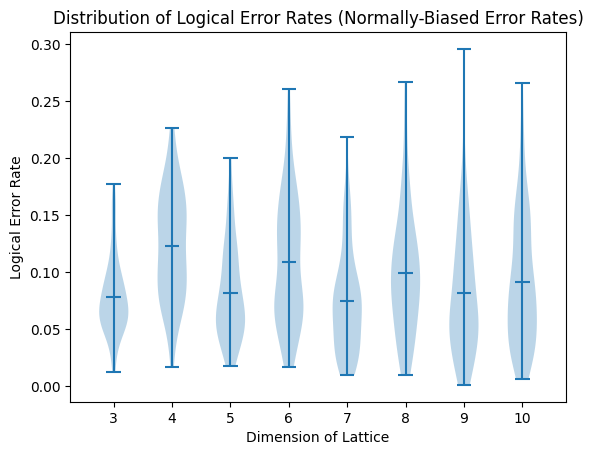

In [91]:
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Dimension of Lattice')

fig, ax = plt.subplots(1,1)
logical_error_rates_data = [logical_error_rates_dict[dim] for dim in dims]
ax.violinplot(logical_error_rates_data, showmeans=True)
ax.set_ylabel("Logical Error Rate")
ax.set_title("Distribution of Logical Error Rates (Normally-Biased Error Rates)")
set_axis_style(ax, dims)
plt.show()

### Test #4
* Fix lattice size
* Strategically choose different gauge fixings
* Plot how logical error rate evolves with physical error rate for each and compare

In [17]:
dim = 7
num_faces_colored = np.linspace(0, (dim - 1)**2, dim)
num_gauge_fixings = 20
phys_err_rates_range = np.linspace(0.0001, 0.05, 10)
num_errors = 200 

logical_errors = {int(num_faces): np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for num_faces in num_faces_colored}


for num_faces in tqdm(num_faces_colored):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), int(num_faces), replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX()
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[int(num_faces)][fix_num][i] += 1


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [02:59<00:00, 25.63s/it]


In [18]:
logical_error_probs = {int(num_faces) : [] for num_faces in logical_errors.keys()}
for num_faces in logical_errors.keys():
    for row in logical_errors[num_faces]:
        logical_error_probs[int(num_faces)].append(row/num_errors)

with open('data/phys_vs_log_err_rate_2.pkl', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

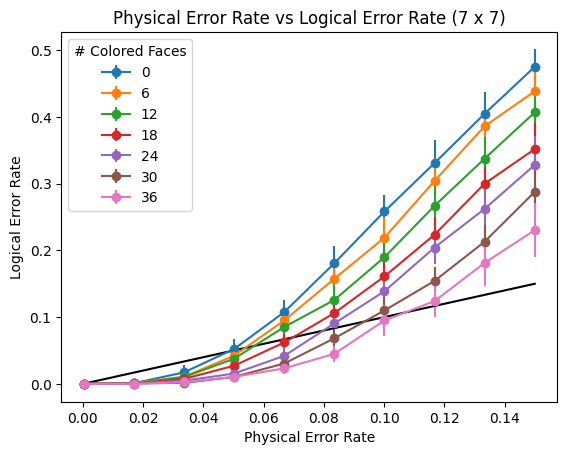

In [19]:
for num_faces in logical_error_probs.keys():
    logical_error_list = np.array(logical_error_probs[num_faces])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(num_faces), fmt='o-')
plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.title('Physical Error Rate vs Logical Error Rate (7 x 7)')
plt.legend(title='# Colored Faces')


In [9]:
dim = 6
num_faces_colored = np.linspace(0, (dim - 1)**2, dim)
num_gauge_fixings = 20
phys_err_rates_range = np.linspace(0, 0.15, 8)
num_errors = 2000 

logical_errors = {int(num_faces): np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for num_faces in num_faces_colored}


for num_faces in tqdm(num_faces_colored):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), int(num_faces), replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX()
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[int(num_faces)][fix_num][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [21:04<00:00, 210.74s/it]


In [10]:
logical_error_probs = {int(num_faces) : [] for num_faces in logical_errors.keys()}
for num_faces in logical_errors.keys():
    for row in logical_errors[num_faces]:
        logical_error_probs[int(num_faces)].append(row/num_errors)

with open('data/phys_vs_log_err_rate_6_by_6.pkl', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

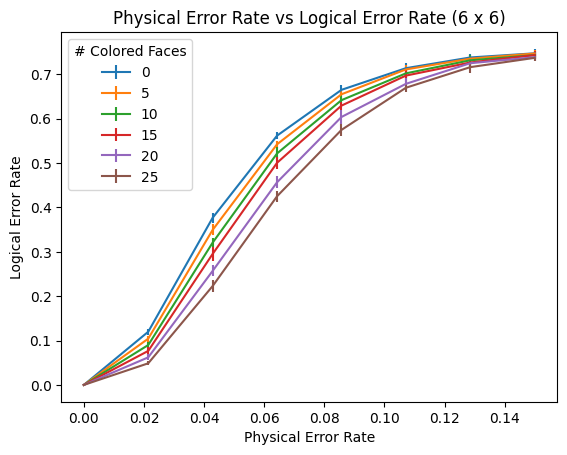

In [11]:
for num_faces in logical_error_probs.keys():
    logical_error_list = np.array(logical_error_probs[num_faces])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.errorbar(phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(num_faces))
plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Physical Error Rate vs Logical Error Rate (6 x 6)')
plt.legend(title='# Colored Faces')

### Belief Propagation + Ordered Statistics Decoding

In [174]:
dim = 8 

rates = [0.03, 0.03, 0.03]
error_probability = 0.09
num_gauge_fixings = 100
num_errors = 2000 
codespace_projection = np.zeros((num_gauge_fixings, num_errors))
logical_errors = np.zeros((num_gauge_fixings, num_errors))
uncorrected_logical_error_rate = np.zeros((num_gauge_fixings, num_errors))
for fix_num in tqdm(range(num_gauge_fixings)):
    lat = Lattice2D(dim, dim)
    coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
    lat.color_lattice(coloring)
    for num_error in range(num_errors):
        E = random_pauli(lat.size(), rates)
        while E == 'I' * lat.size():
            E = random_pauli(lat.size(), rates)
        error = pauli2vector(E)
        pcheckX = lat.pcheckX()
        pcheckZ = lat.pcheckZ() 
        num_qubits = lat.size()
        pcheck = np.vstack((pcheckX, pcheckZ))
        syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
        syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
        Hx = pcheck_clipX(pcheckX)
        Hz = pcheck_clipZ(pcheckZ)
        bpd_X = bposd_decoder(
            Hz,
            error_rate = error_probability,
            channel_probs = [None],
            max_iter = num_qubits, 
            bp_method = "ms",
            ms_scaling_factor = 0,
            osd_method = "osd_cs",
            osd_order = 7
        )
        bpd_Z = bposd_decoder(
            Hx,
            error_rate = error_probability, 
            channel_probs = [None], 
            max_iter = num_qubits, 
            bp_method = "ms", 
            ms_scaling_factor=0, 
            osd_method = "osd_cs", 
            osd_order = 7
        )
        bpd_X.decode(syndromeX)
        bpd_Z.decode(syndromeZ)
        recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
        corrected_error = pauli2vector(E) + recovery % 2 

        if sum(twisted_product(pcheck, corrected_error)) > 0:
            codespace_projection[fix_num][num_error] = 1
        if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
            logical_errors[fix_num][num_error] = 1
        if (twisted_product(pauli2vector(lat.Lx), error) == 1) or (twisted_product(pauli2vector(lat.Lz), error) == 1):
            uncorrected_logical_error_rate[fix_num][num_error] = 1

assert(np.sum(codespace_projection) == 0)

100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


In [175]:
logical_error_rates = []
for row in logical_errors:
    logical_error_rates.append(sum(row)/len(row))

In [176]:
with open('data/logical_err_rate_BP_OSD_test_1', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

Text(0.5, 1.0, 'Average Logical Error Rate over Uniformly-Random Gauge Fixings (BP+OSD)')

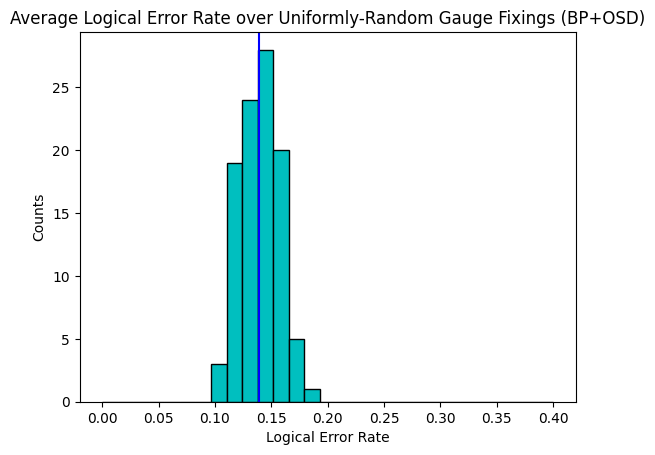

In [177]:
bins = np.linspace(0,0.4, 30)
plt.hist(logical_error_rates, bins, color='c', edgecolor='k')
plt.xlabel("Logical Error Rate")
plt.ylabel("Counts")
plt.axvline(np.mean(logical_error_rates), color='b')
plt.title("Average Logical Error Rate over Uniformly-Random Gauge Fixings (BP+OSD)")

### Test #2

In [5]:
dims = [3,4,5,6,7,8,9,10]
rates = [0.015, 0.015, 0.015]
error_probability = 0.045
num_gauge_fixings = 100
num_errors = 2000 
codespace_projection = {dim : np.zeros((num_gauge_fixings, num_errors)) for dim in dims}
logical_errors = {dim : np.zeros((num_gauge_fixings, num_errors)) for dim in dims}
uncorrected_logical_error_rate = {dim : np.zeros((num_gauge_fixings, num_errors)) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
        lat.color_lattice(coloring)
        for num_error in range(num_errors):
            E = random_pauli(lat.size(), rates)
            while E == 'I' * lat.size():
                E = random_pauli(lat.size(), rates)
            error = pauli2vector(E)
            pcheckX = lat.pcheckX()
            pcheckZ = lat.pcheckZ() 
            num_qubits = lat.size()
            pcheck = np.vstack((pcheckX, pcheckZ))
            syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
            syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
            Hx = pcheck_clipX(pcheckX)
            Hz = pcheck_clipZ(pcheckZ)
            bpd_X = bposd_decoder(
                Hz,
                error_rate = error_probability,
                channel_probs = [None],
                max_iter = num_qubits, 
                bp_method = "ms",
                ms_scaling_factor = 0,
                osd_method = "osd_cs",
                osd_order = 0
            )
            bpd_Z = bposd_decoder(
                Hx,
                error_rate = error_probability, 
                channel_probs = [None], 
                max_iter = num_qubits, 
                bp_method = "ms", 
                ms_scaling_factor=0, 
                osd_method = "osd_cs", 
                osd_order = 0
            )
            bpd_X.decode(syndromeX)
            bpd_Z.decode(syndromeZ)
            recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
            corrected_error = pauli2vector(E) + recovery % 2 

            if sum(twisted_product(pcheck, corrected_error)) > 0:
                codespace_projection[dim][fix_num][num_error] = 1
            if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                logical_errors[dim][fix_num][num_error] = 1
            if (twisted_product(pauli2vector(lat.Lx), error) == 1) or (twisted_product(pauli2vector(lat.Lz), error) == 1):
                uncorrected_logical_error_rate[dim][fix_num][num_error] = 1

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [183]:
logical_error_rates_dict = {dim : [] for dim in dims}
for dim in dims:
    for row in logical_errors[dim]:
        logical_error_rates_dict[dim].append(sum(row)/len(row))

with open('data/logical_err_rate_BP_OSD_test_2.pkl', 'wb') as fp:
    pickle.dump(logical_error_rates_dict, fp)

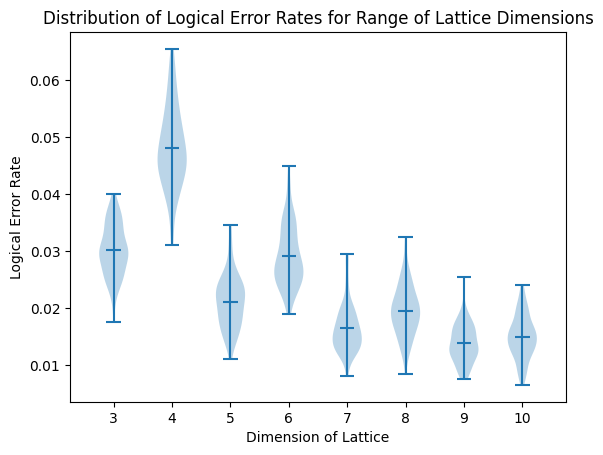

In [184]:
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Dimension of Lattice')

fig, ax = plt.subplots(1,1)
logical_error_rates_data = [logical_error_rates_dict[dim] for dim in dims]
ax.violinplot(logical_error_rates_data, showmeans=True)
ax.set_ylabel("Logical Error Rate")
ax.set_title("Distribution of Logical Error Rates for Range of Lattice Dimensions")
set_axis_style(ax, dims)
plt.show()

### Test #3

In [195]:
dims = [3,4,5,6,7,8,9,10]
num_gauge_fixings = 100
num_errors = 2000 
codespace_projection = {dim : np.zeros((num_gauge_fixings, num_errors)) for dim in dims}
logical_errors = {dim : np.zeros((num_gauge_fixings, num_errors)) for dim in dims}
uncorrected_logical_error_rate = {dim : np.zeros((num_gauge_fixings, num_errors)) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.random.randint(-1, 2, size=(dim - 1)**2)
        lat.color_lattice(coloring)
        for num_error in range(num_errors):
            rate = np.abs(np.random.normal(0.025, 0.01))
            if (rate > 1/3):
                rate = 0.33
            rates = [rate, rate, rate]
            error_probability = np.sum(rates)
            E = random_pauli(lat.size(), rates)
            while E == 'I' * lat.size():
                E = random_pauli(lat.size(), rates)
            error = pauli2vector(E)
            pcheckX = lat.pcheckX()
            pcheckZ = lat.pcheckZ() 
            num_qubits = lat.size()
            pcheck = np.vstack((pcheckX, pcheckZ))
            syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
            syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
            Hx = pcheck_clipX(pcheckX)
            Hz = pcheck_clipZ(pcheckZ)
            bpd_X = bposd_decoder(
                Hz,
                error_rate = error_probability,
                channel_probs = [None],
                max_iter = num_qubits, 
                bp_method = "ms",
                ms_scaling_factor = 0,
                osd_method = "osd_cs",
                osd_order = 1
            )
            bpd_Z = bposd_decoder(
                Hx,
                error_rate = error_probability, 
                channel_probs = [None], 
                max_iter = num_qubits, 
                bp_method = "ms", 
                ms_scaling_factor=0, 
                osd_method = "osd_cs", 
                osd_order = 1
            )
            bpd_X.decode(syndromeX)
            bpd_Z.decode(syndromeZ)
            recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
            corrected_error = pauli2vector(E) + recovery % 2 

            if sum(twisted_product(pcheck, corrected_error)) > 0:
                codespace_projection[dim][fix_num][num_error] = 1
            if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                logical_errors[dim][fix_num][num_error] = 1
            if (twisted_product(pauli2vector(lat.Lx), error) == 1) or (twisted_product(pauli2vector(lat.Lz), error) == 1):
                uncorrected_logical_error_rate[dim][fix_num][num_error] = 1

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [20:22<00:00, 152.80s/it]


In [196]:
logical_error_rates_dict = {dim : [] for dim in dims}
for dim in dims:
    for row in logical_errors[dim]:
        logical_error_rates_dict[dim].append(sum(row)/len(row))

with open('data/logical_err_rate_BP_OSD_test_3.pkl', 'wb') as fp:
    pickle.dump(logical_error_rates_dict, fp)

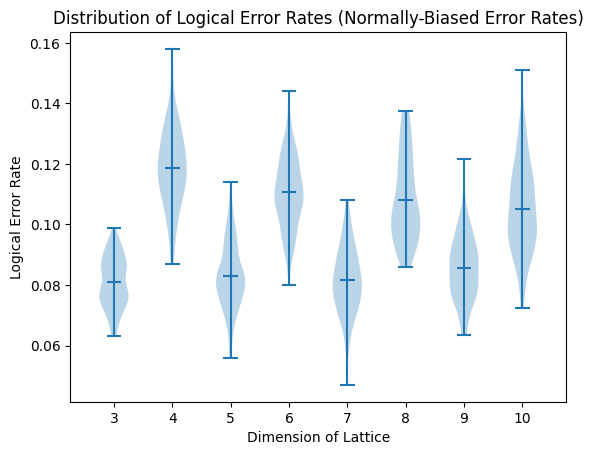

In [197]:
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Dimension of Lattice')

fig, ax = plt.subplots(1,1)
logical_error_rates_data = [logical_error_rates_dict[dim] for dim in dims]
ax.violinplot(logical_error_rates_data, showmeans=True)
ax.set_ylabel("Logical Error Rate")
ax.set_title("Distribution of Logical Error Rates (Normally-Biased Error Rates)")
set_axis_style(ax, dims)
plt.show()

### Test #4
* Fix lattice size
* Strategically choose different gauge fixings
* Plot how logical error rate evolves with physical error rate for each and compare

In [20]:
dim = 7
num_faces_colored = np.linspace(0, (dim - 1)**2, dim)
num_gauge_fixings = 20
phys_err_rates_range = np.linspace(0.0001, 0.05, 10)
num_errors = 200

logical_errors = {int(num_faces): np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for num_faces in num_faces_colored}


for num_faces in tqdm(num_faces_colored):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), int(num_faces), replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            error_probability = np.sum(rates)
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX()
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[int(num_faces)][fix_num][i] += 1

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [02:19<00:00, 19.98s/it]


In [21]:
logical_error_probs = {int(num_faces) : [] for num_faces in logical_errors.keys()}
for num_faces in logical_errors.keys():
    for row in logical_errors[num_faces]:
        logical_error_probs[int(num_faces)].append(row/num_errors)

with open('data/phys_vs_log_err_rate_bp_osd.pkl', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

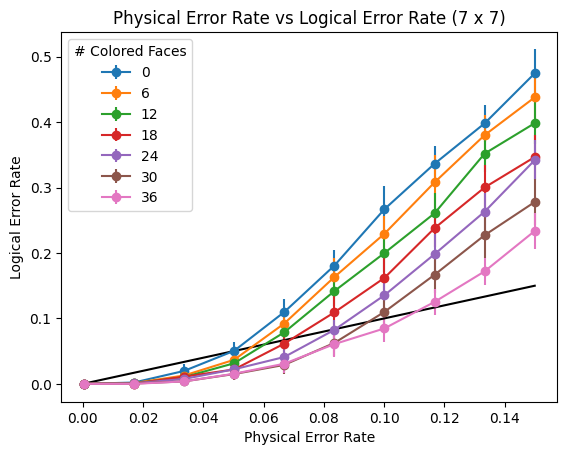

In [22]:
for num_faces in logical_error_probs.keys():
    logical_error_list = np.array(logical_error_probs[num_faces])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(num_faces), fmt='o-')
plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.title('Physical Error Rate vs Logical Error Rate (7 x 7)')
plt.legend(title='# Colored Faces')

In [64]:
dims = [4,5,6,7,8,9,10,11]
num_faces_colored = [dim**2 for dim in dims]
num_guage_fixings = 20 
phys_err_rates_range = np.linspace(0, 0.09, 10)
num_errors = 100 
logical_errors = {dim : np.zeros((num_guage_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate] 
            error_probability = np.sum(rates)
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][fix_num][i] += 1

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [03:25<00:00, 25.67s/it]


In [65]:
logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_bp_osd_2.pkl', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

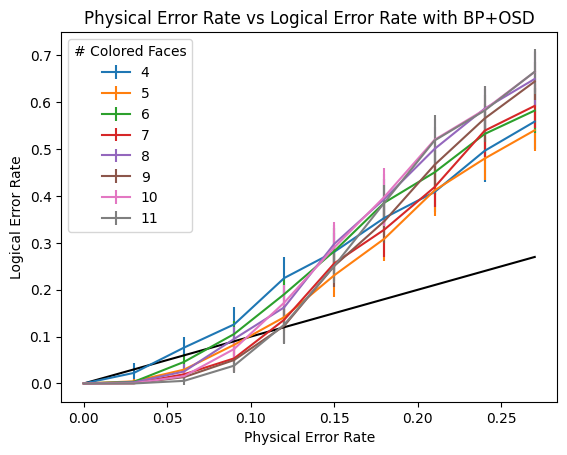

In [66]:
for dim in logical_error_probs.keys():
    logical_error_list = np.array(logical_error_probs[dim])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Physical Error Rate vs Logical Error Rate with BP+OSD')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Colored Faces')

## Comparing BP+OSD and MWPM

In [6]:
dim = 7
num_faces_colored = np.linspace(0, (dim - 1)**2, dim)
num_gauge_fixings = 20
phys_err_rates_range = np.linspace(0, 0.02, 5)
num_errors = 500

logical_errors_mwpm = {int(num_faces): np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for num_faces in num_faces_colored}


for num_faces in tqdm(num_faces_colored):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), int(num_faces), replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX()
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                weightsX = [0 for _ in range(len(Hx[0]))]
                weightsZ = [0 for _ in range(len(Hz[0]))]
                if (np.sum(rates) == 0):
                    # Need to split rates up between Paulis
                    weightsX = [-1 * np.sum(rates) * np.log(np.sum(rates)) for _ in range(len(Hx[0]))]
                    weightsZ = [-1 * np.sum(rates) * np.log(np.sum(rates)) for _ in range(len(Hz[0]))]
                decodingX = Matching.from_check_matrix(Hx, weights=weightsX)
                decodingZ = Matching.from_check_matrix(Hz, weights=weightsZ)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors_mwpm[int(num_faces)][fix_num][i] += 1


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_60170/3402742316.py:37: RuntimeWarning: divide by zero encountered in log
  weightsX = [-1 * np.sum(rates) * np.log(np.sum(rates)) for _ in range(len(Hx[0]))]
/tmp/ipykernel_60170/3402742316.py:37: RuntimeWarning: invalid value encountered in double_scalars
  weightsX = [-1 * np.sum(rates) * np.log(np.sum(rates)) for _ in range(len(Hx[0]))]
/tmp/ipykernel_60170/3402742316.py:38: RuntimeWarning: divide by zero encountered in log
  weightsZ = [-1 * np.sum(rates) * np.log(np.sum(rates)) for _ in range(len(Hz[0]))]
/tmp/ipykernel_60170/3402742316.py:38: RuntimeWarning: invalid value encountered in double_scalars
  weightsZ = [-1 * np.sum(rates) * np.log(np.sum(rates)) for _ in range(len(Hz[0]))]
100%|██████████| 7/7 [05:40<00:00, 48.70s/it]


In [37]:
dim = 7
num_faces_colored = np.linspace(0, (dim - 1)**2, dim)
num_gauge_fixings = 20
phys_err_rates_range = np.linspace(0, 0.02, 5)
num_errors = 500 

logical_errors_bp_osd = {int(num_faces): np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for num_faces in num_faces_colored}


for num_faces in tqdm(num_faces_colored):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), int(num_faces), replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            error_probability = np.sum(rates)
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX()
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors_bp_osd[int(num_faces)][fix_num][i] += 1

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [03:47<00:00, 32.52s/it]


In [7]:
logical_error_probs_mwpm = {int(num_faces) : [] for num_faces in logical_errors_mwpm.keys()}
for num_faces in logical_errors_mwpm.keys():
    for row in logical_errors_mwpm[num_faces]:
        logical_error_probs_mwpm[int(num_faces)].append(row/num_errors)

with open('data/phys_vs_log_err_rate_2.pkl', 'wb') as fp:
    pickle.dump(logical_error_probs_mwpm, fp)

In [44]:
logical_error_probs_bp_osd = {int(num_faces) : [] for num_faces in logical_errors_bp_osd.keys()}
for num_faces in logical_errors_bp_osd.keys():
    for row in logical_errors_bp_osd[num_faces]:
        logical_error_probs_bp_osd[int(num_faces)].append(row/num_errors)

with open('data/phys_vs_log_err_rate_bp_osd.pkl', 'wb') as fp:
    pickle.dump(logical_error_probs_bp_osd, fp)

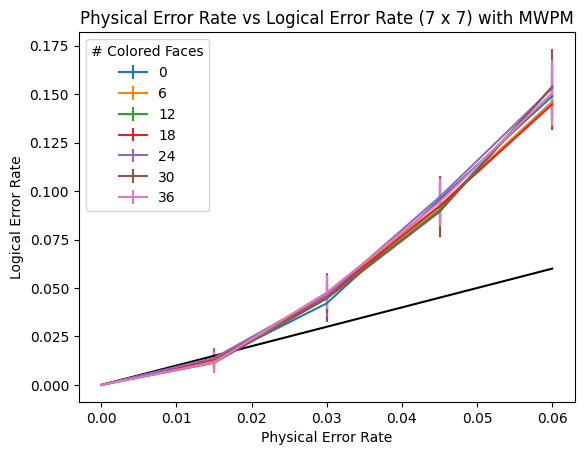

In [8]:
for num_faces in logical_error_probs_mwpm.keys():
    logical_error_list = np.array(logical_error_probs_mwpm[num_faces])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(num_faces))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Physical Error Rate vs Logical Error Rate (7 x 7) with MWPM')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Colored Faces')


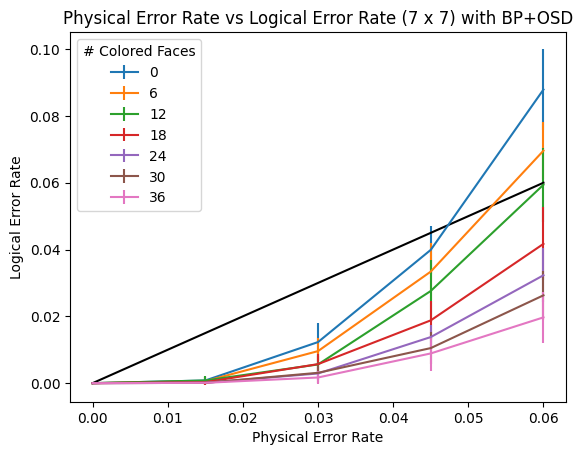

In [49]:
for num_faces in logical_error_probs_bp_osd.keys():
    logical_error_list = np.array(logical_error_probs_bp_osd[num_faces])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(num_faces))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Physical Error Rate vs Logical Error Rate (7 x 7) with BP+OSD')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Colored Faces')

## BP-Matching Performance

In [21]:
dim = 7
num_faces_colored = np.linspace(0, (dim - 1)**2, dim)
num_gauge_fixings = 20
phys_err_rates_range = np.linspace(0, 0.02, 5)
num_errors = 100 

logical_errors_bp_match = {int(num_faces): np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for num_faces in num_faces_colored}


for num_faces in tqdm(num_faces_colored):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), int(num_faces), replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            error_probability = np.sum(rates)
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX()
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                weightsX = bpd_X.log_prob_ratios 
                if (np.max(weightsX) > 20000000):
                    weightsX = np.zeros((lat.size(),))
                weightsZ = bpd_Z.log_prob_ratios
                if (np.max(weightsZ) > 20000000):
                    weightsZ = np.zeros((lat.size(),))
                decodingX = Matching.from_check_matrix(Hx, weights=weightsX)
                decodingZ = Matching.from_check_matrix(Hz, weights=weightsZ)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors_bp_match[int(num_faces)][fix_num][i] += 1

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:58<00:00,  8.32s/it]


In [22]:
logical_error_probs_bp_match = {int(num_faces) : [] for num_faces in logical_errors_bp_match.keys()}
for num_faces in logical_errors_bp_match.keys():
    for row in logical_errors_bp_match[num_faces]:
        logical_error_probs_bp_match[int(num_faces)].append(row/num_errors)

with open('data/phys_vs_log_err_rate_bp_matching.pkl', 'wb') as fp:
    pickle.dump(logical_error_probs_bp_match, fp)

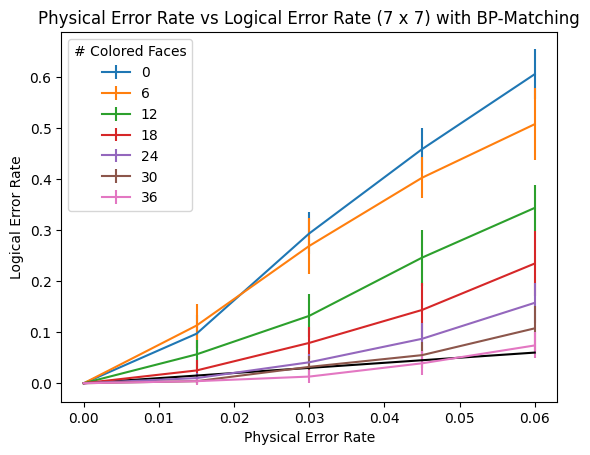

In [23]:
for num_faces in logical_error_probs_bp_match.keys():
    logical_error_list = np.array(logical_error_probs_bp_match[num_faces])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(num_faces))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Physical Error Rate vs Logical Error Rate (7 x 7) with BP-Matching')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Colored Faces')

## BP-Matching for Surface-Like Codes (Even Dimension)

In [81]:
dims = [4,6,8,10]
num_faces_colored = [dim**2 for dim in dims]
num_guage_fixings = 20 
phys_err_rates_range = np.linspace(0, 0.02, 10)
num_errors = 100 
logical_errors = {dim : np.zeros((num_guage_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate] 
            error_probability = np.sum(rates)
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                weightsX = bpd_X.log_prob_ratios 
                if (np.max(weightsX) > 20000000):
                    weightsX = np.zeros((lat.size(),))
                weightsZ = bpd_Z.log_prob_ratios
                if (np.max(weightsZ) > 20000000):
                    weightsZ = np.zeros((lat.size(),))
                decodingX = Matching.from_check_matrix(Hx, weights=weightsX)
                decodingZ = Matching.from_check_matrix(Hz, weights=weightsZ)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][fix_num][i] += 1

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [01:52<00:00, 28.06s/it]


In [60]:
logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_bp_matching_2.pkl', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

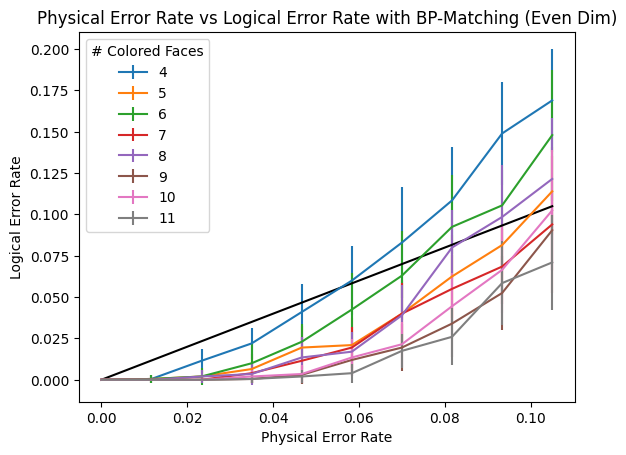

In [61]:
for dim in logical_error_probs.keys():
    logical_error_list = np.array(logical_error_probs[dim])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Physical Error Rate vs Logical Error Rate with BP-Matching (Even Dim)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Colored Faces')

## BP-Matching for Surface-Like Codes (Odd Dimension)

In [83]:
dims = [5,7,9,11]
num_faces_colored = [dim**2 for dim in dims]
num_guage_fixings = 20 
phys_err_rates_range = np.linspace(0, 0.02, 10)
num_errors = 100 
logical_errors = {dim : np.zeros((num_guage_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate] 
            error_probability = np.sum(rates)
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                weightsX = bpd_X.log_prob_ratios 
                if (np.max(weightsX) > 20000000):
                    weightsX = np.zeros((lat.size(),))
                weightsZ = bpd_Z.log_prob_ratios
                if (np.max(weightsZ) > 20000000):
                    weightsZ = np.zeros((lat.size(),))
                decodingX = Matching.from_check_matrix(Hx, weights=weightsX)
                decodingZ = Matching.from_check_matrix(Hz, weights=weightsZ)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][fix_num][i] += 1

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [56]:
logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_bp_matching_3.pkl', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

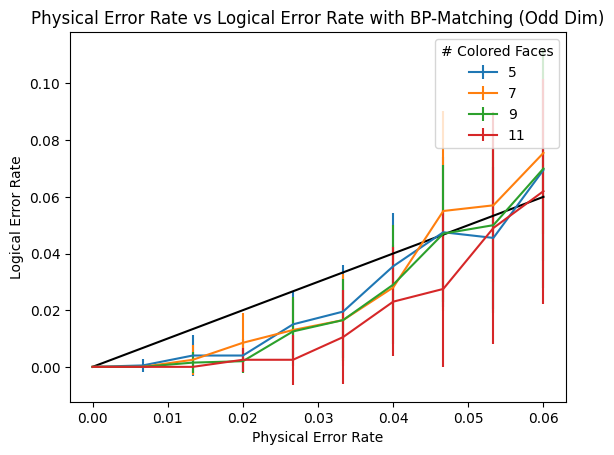

In [57]:
for dim in logical_error_probs.keys():
    logical_error_list = np.array(logical_error_probs[dim])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Physical Error Rate vs Logical Error Rate with BP-Matching (Odd Dim)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Colored Faces')